In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import sys
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [2]:
order=1

NTURN = [128,256,512,1024,1024*2,1024*4]
MU = [0.0,0.01,0.02,0.03,0.04,0.05,0.06]
# NTURN = [1024,1024*2]
# MU = [0.01]
NU = [0.30345]
TAU = [0.4]

nCore_y = 4
nCore_z = 4

NL_c = 0.01
NL_L = 1.8

npt=7668

pipe_radius = 0.02*np.sqrt(2.0)

# 1. Preparation

### 1.1 read InputFile and simplify lattice

In [3]:
beam, lattice = impact.readInputFile('test_toymodel.in');
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0
beam.n_particles = npt

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

reading ImpactZ input file (test_toymodel.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
        
ElemNL = lattice[1]         
ElemNL.n_sckick = 100
ElemNL.length = NL_L
ElemNL.transverse_scale_c = NL_c
ElemNL.pipe_radius = 0.02*np.sqrt(2)

ElemM = lattice[2]
ElemM.nonlinear_insert_length = NL_L

In [5]:
ElemTBT = impact.getElem('TBT')
ElemTBT.pID_begin = 1
ElemTBT.pID_end = npt
lattice.insert(1,ElemTBT)

OUTPUT = impact.getElem('write_raw_ptcl')
OUTPUT.format_id = 2
lattice.append(OUTPUT)

In [6]:
latticeB = copy(lattice[1:-1][::-1])
latticeB.insert(0,copy(lattice[0]))

for i in range(len(latticeB)):
    if 'length' in latticeB[i]:
        latticeB[i].length = -latticeB[i].length
    if latticeB[i].type == 'linear_matrix_map':
        ElemM_B = latticeB[i]
        ElemM_B.nonlinear_insert_length = -NL_L
    elif latticeB[i].type == 'nonlinear_insert':
        ElemNL_B = latticeB[i]

In [7]:
def normalize(data,alfx,betx):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data,alfx,betx):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

### 1.2. generate particles

In [8]:
testP = 0.0
k=0
q_m = beam.multi_charge.q_m[0]
pTest = []
nx = 100
xmax = 0.98
for x in np.linspace(-xmax,xmax,nx):
    for y in np.linspace(-xmax,xmax,nx):
        if x**2+y**2<=xmax**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k]) 
pTest = np.array(pTest)

In [9]:
def run(tau,nu,mu):
    alfx = np.tan(np.pi*nu)
    betx = NL_L/np.sin(2.0*np.pi*nu)
    pData = copy(pTest)
    unnormalize(pData,alfx,betx)
    impact.writeParticleData(pData, ke, mass, freq)
    
    lattice[0].turns = NTURN[0]
    ElemNL.strength_t = tau
    ElemNL.tune_advance = nu
    ElemM.tune_advance_x = mu
    ElemM.tune_advance_y = mu
    ElemM.nonlinear_insert_tuneAdvance = nu
    ElemTBT.file_id = NTURN[0]
    OUTPUT.file_id = NTURN[0]
    OUTPUT.turn = NTURN[0]
    beam.distribution.distribution_type = 'ReadFile'
    impact.writeInputFile(beam,lattice) 
    impact.run(beam,order=order)
    for nturn in NTURN[:-1]:
        lattice[0].turns = nturn
        ElemTBT.file_id = nturn*2
        OUTPUT.turn = nturn
        OUTPUT.file_id = nturn*2
        beam.distribution.distribution_type = 'ReadFile_binary'
        beam.distribution.file_id = nturn
        impact.writeInputFile(beam,lattice) 
        impact.run(beam,order=order)
        
        
    ElemNL_B.strength_t = tau
    ElemNL_B.tune_advance = nu
    ElemM_B.tune_advance_x               =-mu
    ElemM_B.tune_advance_y               =-mu
    ElemM_B.nonlinear_insert_tuneAdvance =-nu
    for nturn in NTURN[:-1]:
        latticeB[0].turns = nturn
        latticeB[-1].file_id = 100000+nturn
        beam.distribution.distribution_type = 'ReadFile_binary'
        beam.distribution.file_id = nturn
        impact.writeInputFile(beam,latticeB) 
        impact.run(beam,order=order)

In [10]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)


def getData(tau,nu,mu):
    alfx = np.tan(np.pi*nu)
    betx = NL_L/np.sin(2.0*np.pi*nu)
    iTBT = {}
    TBT = {}
    Npt = {}
    
    
    # read TBT data
    for nturn in NTURN:
        iTBT[nturn],TBT[nturn] = impact.readTBT(nturn,ke,mass,freq)
        TBT[nturn] = TBT[nturn][:,:4,:]
        Npt[nturn] = len(iTBT[nturn])
    for nturn in NTURN[:-1]:
        iTBT[-nturn],TBT[-nturn] = impact.readTBT(100000+nturn,ke,mass,freq)
        TBT[-nturn] = TBT[-nturn][::-1,:4,:]
        Npt[-nturn] = len(iTBT[-nturn])

        
    # normalize TBT data
    XF = {}
    YF = {}
    for i in range(len(NTURN)):
        nturn = NTURN[i]
        npt = len(iTBT[nturn])
        XF[nturn]=np.zeros((nturn,npt),dtype=np.complex)
        YF[nturn]=np.zeros((nturn,npt),dtype=np.complex)
        iturn = 0
        for j in range(i+1):
            jturn = NTURN[j]
            itmp = np.in1d(iTBT[jturn],iTBT[nturn])
            tmp = TBT[jturn][:,:,itmp]
            XF[nturn][iturn:jturn] = (tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
            YF[nturn][iturn:jturn] = (tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
            iturn = jturn
    XB = {}
    YB = {}
    for i in range(len(NTURN)-1):
        nturn = NTURN[i]
        npt = len(iTBT[-nturn])
        XB[nturn]=np.zeros((nturn,npt),dtype=np.complex)
        YB[nturn]=np.zeros((nturn,npt),dtype=np.complex)
        tmp = TBT[-nturn]
        XB[-nturn]=(tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
        YB[-nturn]=(tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
        iturn = 0
        for j in range(i+1):
            jturn = NTURN[j]
            itmp = np.in1d(iTBT[jturn],iTBT[-nturn])
            tmp = TBT[jturn][:,:,itmp]
            XB[nturn][iturn:jturn] = (tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
            YB[nturn][iturn:jturn] = (tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
            iturn = jturn

            
    #FD
    tuneXbefore= {}
    tuneYbefore= {}
    Xdiff = {}
    Ydiff = {}
    Adiff = {}
    for nturn in NTURN[:-1]:
        nturn2 = 2*nturn
        npt = len(XF[nturn2][0,:])
        tuneXbefore[nturn] = np.zeros(npt)
        tuneYbefore[nturn] = np.zeros(npt)
        Xdiff[nturn] = np.zeros(npt)
        Ydiff[nturn] = np.zeros(npt)
        Adiff[nturn] = np.zeros(npt)
        for i in range(npt):
            signal = XF[nturn2][:nturn,i] -np.mean(XF[nturn2][:nturn,i])
            tuneXbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
            signal = XF[nturn2][nturn:,i] -np.mean(XF[nturn2][nturn:,i])
            tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
            Xdiff[nturn][i] = getClosestDiff(tuneXbefore[nturn][i],tune)
            signal = YF[nturn2][:nturn,i] -np.mean(YF[nturn2][:nturn,i])
            tuneYbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
            signal = YF[nturn2][nturn:,i] -np.mean(YF[nturn2][nturn:,i])
            tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
            Ydiff[nturn][i] = getClosestDiff(tuneYbefore[nturn][i],tune)

        Adiff[nturn] = np.sqrt(Xdiff[nturn]**2 +Ydiff[nturn]**2)
#         print(np.min(Adiff[nturn]),np.max(Adiff[nturn]),np.sum(np.isnan(Adiff[nturn])))
        Adiff[nturn] = np.log10(Adiff[nturn]+1.0e-6)
        Xdiff[nturn] = np.log10(Xdiff[nturn]+1.0e-6)
        Ydiff[nturn] = np.log10(Ydiff[nturn]+1.0e-6)
            
    #FB
    for nturn in NTURN[:-1]:
        nturn = -nturn
        Adiff[nturn] = np.abs(XB[nturn][0]-XB[-nturn][0])**2 + np.abs(YB[nturn][0]-YB[-nturn][0])**2
        Adiff[nturn] = np.sqrt(Adiff[nturn])
#         print(np.min(Adiff[nturn]),np.max(Adiff[nturn]),np.sum(np.isnan(Adiff[nturn])))
        Adiff[nturn] = np.log10(Adiff[nturn]+1.0e-100)
        
    X = {}
    Y = {}
    for n in NTURN[:-1]:
        X[ n]=np.real(XF[2*n][0,:])
        Y[ n]=np.real(YF[2*n][0,:])
        X[-n]=np.real(XB[n][0,:])
        Y[-n]=np.real(YB[n][0,:])
        
    return {'X':X,'Y':Y,'c':Adiff}#,'rawX':XB,'rawY':YB}

In [ ]:
data = {}
for tau in TAU:
    for nu in NU:
        for mu in MU:
            print('<<<< nu='+str(nu)+'.tau='+str(tau)+'.mu='+str(mu)+' >>>>')
            run(tau,nu,mu)
            data['nu='+str(nu)+'.tau='+str(tau)+'.mu='+str(mu)] = getData(tau,nu,mu)

<<<< nu=0.30345.tau=0.4.mu=0.0 >>>>
<<<< nu=0.30345.tau=0.4.mu=0.01 >>>>


In [ ]:
import pickle
pickle.dump(data,open('DA.data.nu='+str(NU[0])+'.tau=0.4.pickle','wb'))
data = pickle.load(open('DA.data.nu='+str(NU[0])+'.tau=0.4.pickle','rb'))

In [ ]:
data.keys()

In [ ]:
def getH(x,y):
    z = x+1j*y
    U = z/np.sqrt(1-z*z)*np.arcsin(z)
    U = U.real
    return 0.5*(x*x+y*y) + 0.4*U

In [ ]:
def getI(x,y):
    z = x+1j*y
    W = 2*x/np.sqrt(1-z*z)*np.arcsin(z)
    W = W.real
    return x*x + 0.4*W

In [ ]:
def I2Hobj(x):
    measI = getI(x[0],x[1])
    measH = getH(x[0],x[1])
    return (measI-2*measH)**2

In [ ]:
from scipy.optimize import minimize
arc = []
for i in range(64):
    x = 0.65*np.random.rand() + 0.35
    y = np.sqrt(2*(x-0.35))
    result = minimize(I2Hobj,[0.4+0.02*i,0.01+0.04*i],tol=1.0e-10)
    if result.x[1] > 1.0e-4 and result.fun < 1.0e-16:        
        arc.append(result.x)

In [ ]:
arc = np.array(arc)
arc = np.sort(arc,axis=0)
arc2 = arc[::-1,:].copy()
arc2[:,1] = -arc2[:,1]
n=len(arc)
arc3 = np.zeros([2*n,2])
arc3[n:,:] =arc
arc3[:n,:] =arc2
arc2 = None
arc = arc3
arc3 = None

plt.figure(figsize=(4,4))
plt.plot(arc[:,0],arc[:,1],lw=3)
plt.xlim(-1.2,1.2)
plt.ylim(-1,1)

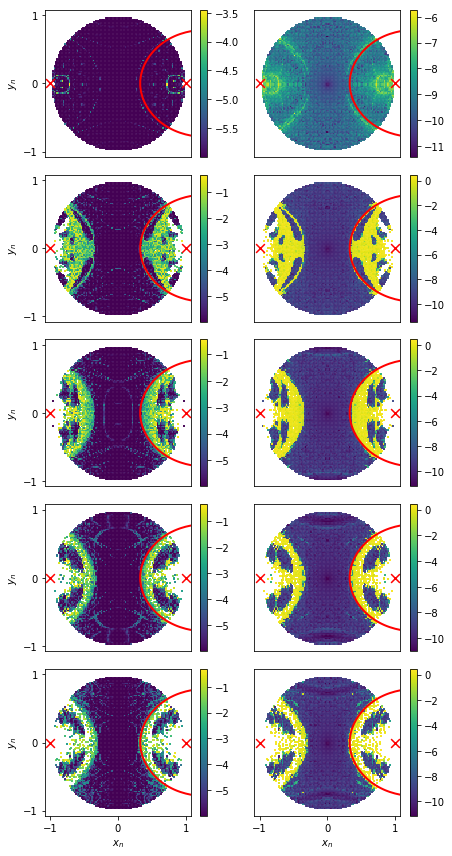

In [21]:
deco = 'nu='+str(NU[0])+'.tau=0.4.mu='
n = 1024
fig = plt.figure(figsize=[6.4,12])
cmap = [0]*10
for i in range(5):
    mu=MU[i]
    plt.subplot(5,2,1+2*i)
    cmap[2*i]=plt.scatter(data[deco+str(mu)]['X'][n],data[deco+str(mu)]['Y'][n],c=data[deco+str(mu)]['c'][n],s=1.0,marker='s')
    plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
    plt.plot(arc[:,0], arc[:,1],'r',lw=2)
    if i==4:
        plt.xticks([-1,0,1])
    else:
        plt.xticks([])
    plt.yticks([-1,0,1])
    plt.xlim(-0.98*1.1,0.98*1.1)
    plt.ylim(-0.98*1.1,0.98*1.1)
    if i==4:
        plt.xlabel('$x_n$')  
    plt.ylabel('$y_n$')
    plt.colorbar(cmap[2*i])
    
    plt.subplot(5,2,2+2*i)
    cmap[2*i+1]=plt.scatter(data[deco+str(mu)]['X'][-n],data[deco+str(mu)]['Y'][-n],c=data[deco+str(mu)]['c'][-n],s=1.0,marker='s')
    plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
    plt.plot(arc[:,0], arc[:,1],'r',lw=2)
    if i==4:
        plt.xticks([-1,0,1])
    else:
        plt.xticks([])
    plt.yticks([])
    plt.xlim(-0.98*1.1,0.98*1.1)
    plt.ylim(-0.98*1.1,0.98*1.1)
    if i==4:
        plt.xlabel('$x_n$')  
    plt.colorbar(cmap[2*i+1])
plt.tight_layout()
plt.savefig('FMA.FB.nu='+str(NU[0])+'.mu=0.0-0.04.turn=1024.png',dpi=270)
plt.savefig('FMA.FB.nu='+str(NU[0])+'.mu=0.0-0.04.turn=1024.eps',dpi=270)

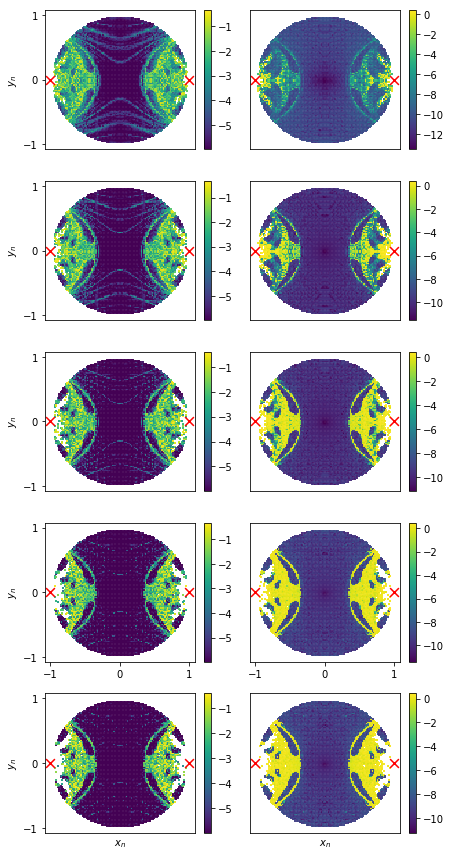

In [22]:
deco = 'nu='+str(NU[0])+'.tau=0.4.mu=0.01'
n = 1024
fig = plt.figure(figsize=[6.4,12*5/5])
cmap = [0]*10
for i in range(5):
    n=NTURN[i]
    plt.subplot(5,2,1+2*i)
    cmap[2*i]=plt.scatter(data[deco]['X'][n],data[deco]['Y'][n],c=data[deco]['c'][n],s=1.0,marker='s')
    plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
    if i==3:
        plt.xticks([-1,0,1])
    else:
        plt.xticks([])
    plt.yticks([-1,0,1])
    plt.xlim(-0.98*1.1,0.98*1.1)
    plt.ylim(-0.98*1.1,0.98*1.1)
    if i==4:
        plt.xlabel('$x_n$')  
    plt.ylabel('$y_n$')
    plt.colorbar(cmap[2*i])
    
    plt.subplot(5,2,2+2*i)
    cmap[2*i+1]=plt.scatter(data[deco]['X'][-n],data[deco]['Y'][-n],c=data[deco]['c'][-n],s=1.0,marker='s')
    plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
    if i==3:
        plt.xticks([-1,0,1])
    else:
        plt.xticks([])
    plt.yticks([])
    plt.xlim(-0.98*1.1,0.98*1.1)
    plt.ylim(-0.98*1.1,0.98*1.1)
    if i==4:
        plt.xlabel('$x_n$')  
    plt.colorbar(cmap[2*i+1])
plt.tight_layout()
plt.savefig('FMA.FB.nu='+str(NU[0])+'.mu=0.01.turn=128-2048.png',dpi=270)
plt.savefig('FMA.FB.nu='+str(NU[0])+'.mu=0.01.turn=128-2048.eps',dpi=270)